In [4]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow,imread
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
import os


In [5]:
train_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
train_df ['ID'] = train_df['ID'].map(lambda x: f'{x}.png')
train_df['Male']= train_df['Male'].map(lambda x: 1 if (x == True) else 0)
train_df

,ID,Male,Boneage
0,1377.png,0,180
1,1378.png,0,12
2,1379.png,0,94
3,1380.png,1,120
4,1381.png,0,82
...,...,...,...
12606,15605.png,0,50
12607,15606.png,0,113
12608,15608.png,0,55
12609,15609.png,1,150


In [6]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')
test_df

,ID,Male
0,4360.png,True
1,4361.png,True
2,4362.png,True
3,4363.png,True
4,4364.png,True
...,...,...
195,4555.png,False
196,4556.png,False
197,4557.png,False
198,4558.png,False


In [7]:
val_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_val.csv')
val_df['ID'] = val_df['ID'].map(lambda x: f'{x}.png')
val_df['Male']= val_df['Male'].map(lambda x: 1 if (x == True) else 0)
val_df

,ID,Male,Boneage
0,1386.png,0,30
1,1392.png,1,162
2,1397.png,0,18
3,1401.png,0,132
4,1410.png,1,57
...,...,...,...
1420,15592.png,0,42
1421,15601.png,0,132
1422,15607.png,1,186
1423,15611.png,0,120


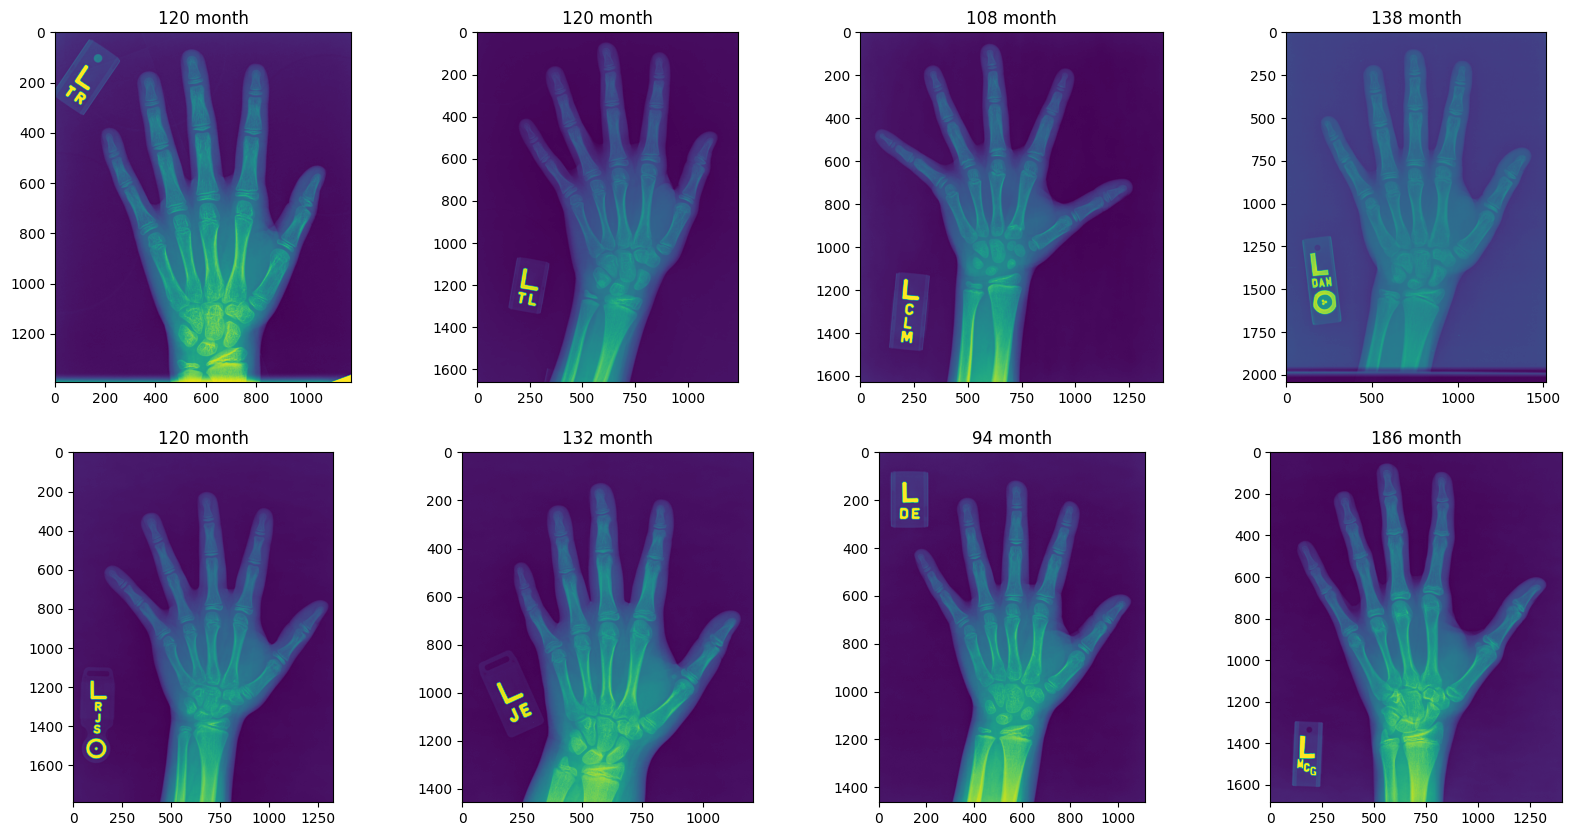

In [8]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
val_dir= 'dataset/RSNA_val/images'
sample = train_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [9]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator()

train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='ID',
    y_col='Boneage',
    target_size=(256,256),
    color_mode='grayscale',
    class_mode='raw',
    classes=None,
    batch_size=32,
    shuffle=True,
    save_format='png',
    interpolation='nearest',
)

Found 12611 validated image filenames.


In [10]:
test_dg = core_dg.flow_from_dataframe(
    test_df,
    x_col='ID',
    directory=test_dir,
    class_mode=None,
    )

Found 200 validated image filenames.


In [11]:
val_dg = core_dg.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='ID',
    y_col='Boneage',
    target_size=(256,256),
    color_mode='grayscale',
    class_mode='raw',
    classes=None,
    batch_size=32,
    shuffle=True,
    save_format='png',
    interpolation='nearest',
)

Found 1425 validated image filenames.


In [12]:
from keras.layers import Dense, MaxPooling2D, Input, Conv2D, SeparableConv2D, Dropout, BatchNormalization, Flatten, ReLU, Add, GlobalAveragePooling2D
from keras.metrics import MeanAbsoluteError
from keras.models import Model

CNN Model

In [13]:
input_shape=(256,256,1)
dropout_rate = 0.35

model_input= Input(shape=input_shape)

x = Conv2D(32,(3,3),activation='relu',padding='same')(model_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Flatten()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
model_output = Dense(1,activation='linear')(x)


In [14]:
model = Model(model_input,model_output)

model.compile(loss='mae',optimizer='adam',metrics=[MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         


                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)      

In [19]:
model.fit_generator(train_dg, epochs = 4)

C:\Users\prkna\AppData\Local\Temp\ipykernel_20988\796460892.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_dg, epochs = 4)


Epoch 1/4
395/395 [==============================] - 355s 898ms/step - loss: 23.5777 - mean_absolute_error: 23.5777
Epoch 2/4
395/395 [==============================] - 407s 1s/step - loss: 21.6529 - mean_absolute_error: 21.6529
Epoch 3/4
395/395 [==============================] - 427s 1s/step - loss: 20.3914 - mean_absolute_error: 20.3914
Epoch 4/4
395/395 [==============================] - 441s 1s/step - loss: 19.4395 - mean_absolute_error: 19.4395


In [20]:
model.save('checkpoint_cnn.h5')

In [15]:
model.load_weights('checkpoint_cnn.h5')

In [16]:
score = model.evaluate(val_dg)

45/45 [==============================] - 69s 2s/step - loss: 22.6331 - mean_absolute_error: 22.6331


In [17]:
print(f"MAE for CNN model: {score[0]}")

MAE for CNN model: 22.633068084716797


In [18]:
import cv2

Train data prediction

In [19]:
for _,i in train_df.head(10).iterrows():
    img = cv2.imread(f"{train_dir}/{i['ID']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1, 256, 256, 1))
    y_true =i['Boneage']
    y_pred = round(model.predict(img,verbose=0)[0][0])
    print(f"true val:{y_true}\npred val:{y_pred}\ndiff val:{abs(y_true-y_pred)}")
    print('-'*30)

true val:180
pred val:164
diff val:16
------------------------------
true val:12
pred val:80
diff val:68
------------------------------
true val:94
pred val:104
diff val:10
------------------------------
true val:120
pred val:172
diff val:52
------------------------------
true val:82
pred val:74
diff val:8
------------------------------
true val:138
pred val:170
diff val:32
------------------------------
true val:150
pred val:135
diff val:15
------------------------------
true val:156
pred val:138
diff val:18
------------------------------
true val:36
pred val:39
diff val:3
------------------------------
true val:138
pred val:145
diff val:7
------------------------------


Validation data prediction

In [20]:
for _,i in val_df.head(10).iterrows():
    img = cv2.imread(f"{val_dir}/{i['ID']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1, 256, 256, 1))
    y_true =i['Boneage']
    y_pred = round(model.predict(img,verbose=0)[0][0])
    print(f"true val:{y_true}\npred val:{y_pred}\ndiff val:{abs(y_true-y_pred)}")
    print('-'*30)

true val:30
pred val:87
diff val:57
------------------------------
true val:162
pred val:130
diff val:32
------------------------------
true val:18
pred val:75
diff val:57
------------------------------
true val:132
pred val:98
diff val:34
------------------------------
true val:57
pred val:113
diff val:56
------------------------------
true val:150
pred val:105
diff val:45
------------------------------
true val:24
pred val:71
diff val:47
------------------------------
true val:120
pred val:49
diff val:71
------------------------------
true val:16
pred val:85
diff val:69
------------------------------
true val:120
pred val:65
diff val:55
------------------------------
